In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

In [4]:
import torch
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from models.DDPM import UnconditionalUNet, DiffusionModel

def get_dataloader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t - 0.5) * 2)  # Scale images to [-1, 1]
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

if __name__ == '__main__':
    unet = UnconditionalUNet(in_channels=1, base_channels=64, time_emb_dim=128)
    diffusion = DiffusionModel(unet, timesteps=1000, beta_start=1e-4, beta_end=0.02, lr=2e-4)

    trainer = pl.Trainer(
        max_epochs=30,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None
    )
    dataloader = get_dataloader(batch_size=128)

    trainer.fit(diffusion, dataloader)

    samples = diffusion.sample(num_samples=16, ddim_steps=50)
    save_image(samples, "unconditional_ddim_samples.png", nrow=4, normalize=True)
    print("Sampling complete. Check 'unconditional_ddim_samples.png' for generated images.")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UnconditionalUNet | 4.0 M  | train
----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.812    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Sampling complete. Check 'unconditional_ddim_samples.png' for generated images.


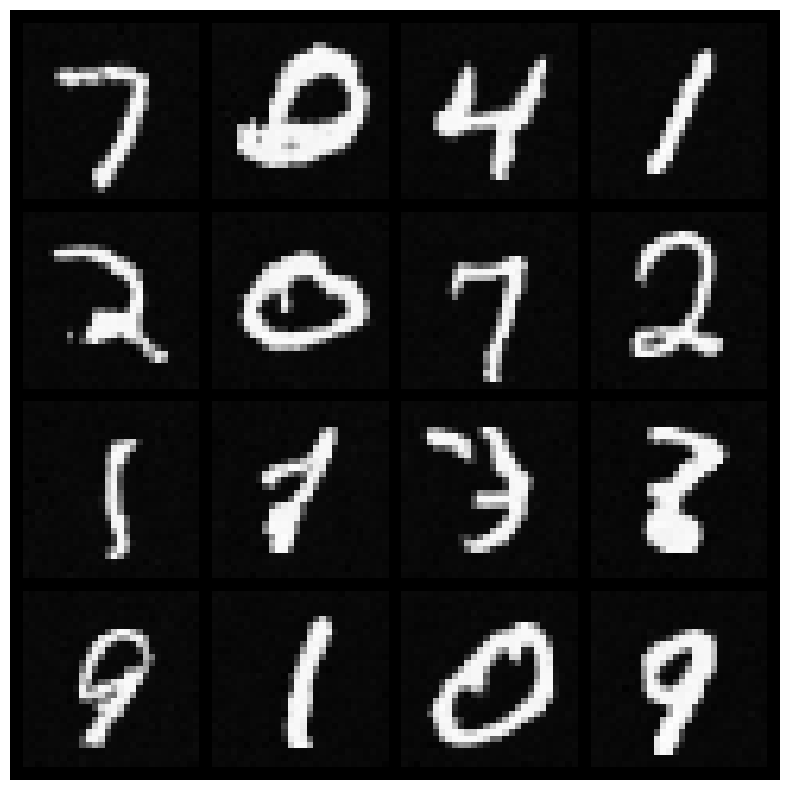

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
img_pil = Image.open("/content/unconditional_ddim_samples.png")
plt.imshow(img_pil)
plt.axis('off')
plt.show()